In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from PIL import Image
from ipywidgets import interact, IntSlider
from ultralytics import YOLO

## Creating Contours
To use cutout images, just change dir from original images to cutout_images, and visa versa

In [2]:
input_dir = 'YOLO/Segmentation/original images/images'
output_dir = 'YOLO/Segmentation/original images/labels'

In [3]:
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def draw_contour(event, x, y, flags, param):
    global drawing, current_contour

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        current_contour.append((x, y))
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            current_contour.append((x, y))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        current_contour.append((x, y))

def convert_to_yolo_format(contour, img_width, img_height):
    yolo_contour = []
    for point in contour:
        x = point[0] / img_width
        y = point[1] / img_height
        yolo_contour.append(x)
        yolo_contour.append(y)
    return yolo_contour

# Function to load the list of already processed images
def load_processed_images(output_dir):
    processed_images = set()
    for label_file in os.listdir(output_dir):
        if label_file.endswith('.txt'):
            processed_images.add(label_file.replace('.txt', ''))
    return processed_images

# Load the list of already processed images
processed_images = load_processed_images(output_dir)

# Iterate through images in the input directory
for image_name in os.listdir(input_dir):
    image_base_name = os.path.splitext(image_name)[0]
    
    if image_base_name in processed_images:
        print(f"Skipping {image_name}, already processed.")
        continue

    if image_name.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_dir, image_name)
        image = cv2.imread(image_path)
        img_height, img_width = image.shape[:2]
        
        contours = []
        current_contour = []
        drawing = False

        # Create a window and set a mouse callback to draw the contour
        cv2.namedWindow(image_name)
        cv2.setMouseCallback(image_name, draw_contour)

        while True:
            temp_image = image.copy()
            for contour in contours:
                cv2.polylines(temp_image, [np.array(contour)], isClosed=True, color=(0, 255, 0), thickness=2)
            
            if len(current_contour) > 1:
                cv2.polylines(temp_image, [np.array(current_contour)], isClosed=True, color=(255, 0, 0), thickness=2)
            
            cv2.imshow(image_name, temp_image)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('n'):  # Press 'n' to finalize the current contour and start a new one
                if len(current_contour) > 2:  # Ensure there is a valid contour
                    contours.append(current_contour)
                current_contour = []

            elif key == ord('q'):  # Press 'q' to save and move to the next image
                if len(current_contour) > 2:  # Finalize the last contour if it's valid
                    contours.append(current_contour)
                
                if contours:  # Ensure there are contours to save
                    label_path = os.path.join(output_dir, image_name.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
                    with open(label_path, 'w') as f:
                        for contour in contours:
                            yolo_contour = convert_to_yolo_format(contour, img_width, img_height)
                            f.write(f'0 {" ".join(map(str, yolo_contour))}\n')
                break

            elif key == ord('r'):  # Press 'r' to reset the current contour
                current_contour = []

        cv2.destroyAllWindows()

print("Contour drawing complete.")

Skipping p1036.jpg, already processed.
Skipping p1988.jpg, already processed.
Skipping p417.jpg, already processed.
Skipping p1977.jpg, already processed.
Skipping p1963.jpg, already processed.
Skipping p1234.jpg, already processed.
Skipping p1208.jpg, already processed.
Skipping p1354.jpg, already processed.
Skipping p1142.jpg, already processed.
Skipping p1156.jpg, already processed.
Skipping p1181.jpg, already processed.
Skipping p1195.jpg, already processed.
Skipping p1194.jpg, already processed.
Skipping p1180.jpg, already processed.
Skipping p1157.jpg, already processed.
Skipping p1143.jpg, already processed.
Skipping p1355.jpg, already processed.
Skipping p1433.jpg, already processed.
Skipping p1427.jpg, already processed.
Skipping p1341.jpg, already processed.
Skipping p1221.jpg, already processed.
Skipping p1235.jpg, already processed.
Skipping p1962.jpg, already processed.
Skipping p1976.jpg, already processed.
Skipping p416.jpg, already processed.
Skipping p1037.jpg, already

In [2]:
base_dir = 'YOLO/Segmentation/original images/'
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')
labelled_images_dir = os.path.join(base_dir, 'labelled_images')

os.makedirs(labelled_images_dir, exist_ok=True)

In [3]:
for image_file in os.listdir(images_dir):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):
        # Generate the corresponding label file name
        label_file = os.path.splitext(image_file)[0] + '.txt'
        
        # Check if the corresponding label file exists in the labels directory
        if os.path.exists(os.path.join(labels_dir, label_file)):
            # Copy the image to the labelled_images directory
            shutil.copy(os.path.join(images_dir, image_file), os.path.join(labelled_images_dir, image_file))

print("Images with corresponding labels have been copied to the labelled_images directory.")

Images with corresponding labels have been copied to the labelled_images directory.


## Fine Tuning YOLO Model

In [ ]:
model = YOLO('YOLO/Segmentation/yolov8m-seg.pt')

In [ ]:
results = model.train(
    data='YOLO/Segmentation/data.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    workers=4,
    name='pothole_segmentation',  # Name of the training run
    save_period=10,
    project='YOLO/segmentation',  # Project directory where results are saved
    cache=True,
    patience=10,
    augment=True,
    lr0=0.01,
    optimizer='AdamW',
    rect=True,
    resume=False,
    amp=True,
    exist_ok=True  # Allow overwriting the existing directory
)

In [ ]:
model.save('YOLO/Segmentation/best_model_2.pt')

# Testing Model

In [2]:
model = YOLO('../DONT TOUCH MODELS/best_segmentation_model.pt')
#model.eval()
pothole_model = YOLO('../DONT TOUCH MODELS/best_pothole_id_model.pt')

In [3]:
def plot_pothole_contour(image, bbox_model, segmentation_model, contour_threshold=0.5):
    """
    Predict and plot the pothole contour based on the bounding box and segmentation model.
    :param image: Input image as a numpy array.
    :param bbox_model: Trained YOLO bounding box model for detecting potholes.
    :param segmentation_model: Trained YOLO segmentation model for detecting pothole contours.
    :param contour_threshold: Threshold to apply to the mask for contour detection.
    :return: Image with the pothole contour or bounding box drawn.
    """
    # Step 1: Use the bounding box model to detect the pothole
    bbox_results = bbox_model.predict(source=image, save=False, verbose=False)

    if len(bbox_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        bbox = bbox_results[0].boxes.xyxy.cpu().numpy()[0].astype(int)

        # Step 2: Crop the image to the bounding box
        x1, y1, x2, y2 = bbox
        cropped_image = image[y1:y2, x1:x2]

        # Step 3: Use the segmentation model to predict the contour
        contour_results = segmentation_model.predict(source=cropped_image, conf=0.01, save=False, verbose=False)

        if contour_results[0].masks is not None:
            # Extract all the predicted masks
            masks = contour_results[0].masks.data.cpu().numpy()

            # Extract the confidence scores for the masks
            mask_scores = contour_results[0].boxes.conf.cpu().numpy()

            # Find the mask with the highest confidence score
            max_conf_idx = np.argmax(mask_scores)
            best_mask = masks[max_conf_idx]

            # Apply threshold to mask
            mask = (best_mask > contour_threshold).astype(np.uint8) * 255

            # Ensure the mask size matches the cropped image size
            mask = cv2.resize(mask, (cropped_image.shape[1], cropped_image.shape[0]))

            # Find contours in the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                # Step 4: Draw the predicted contours on the original image
                cv2.drawContours(image[y1:y2, x1:x2], contours, -1, (0, 255, 0), 2)  # Green contours
            else:
                # If no contours are found, draw the bounding box
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue bounding box

        else:
            # If no masks are found, draw the bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue bounding box

    else:
        print(f"No pothole detected in the image: {image_path}")

    return image

# Example usage:
image_path = 'YOLO/Segmentation/pothole_cutouts/images/p1142.jpg'
image = cv2.imread(image_path)

# Apply the prediction function using the bounding box and segmentation model
output_image = plot_pothole_contour(image.copy(), pothole_model, model, contour_threshold=0.5)

# Convert to RGB for displaying
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis('off')
plt.show()

In [ ]:
image_path = 'YOLO/Segmentation/images/pic-155-_jpg.rf.a0f2c54c02aec34c0ca6138b4635c155.jpg'
image = Image.open(image_path)

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
model.predict(image, conf=0.00000000000001)[0]

# Testing model on original images

In [69]:
segmentation_model = YOLO('YOLO/Segmentation/best.pt')
#model.eval()
pothole_model = YOLO('../DONT TOUCH MODELS/best_pothole_id_model.pt')

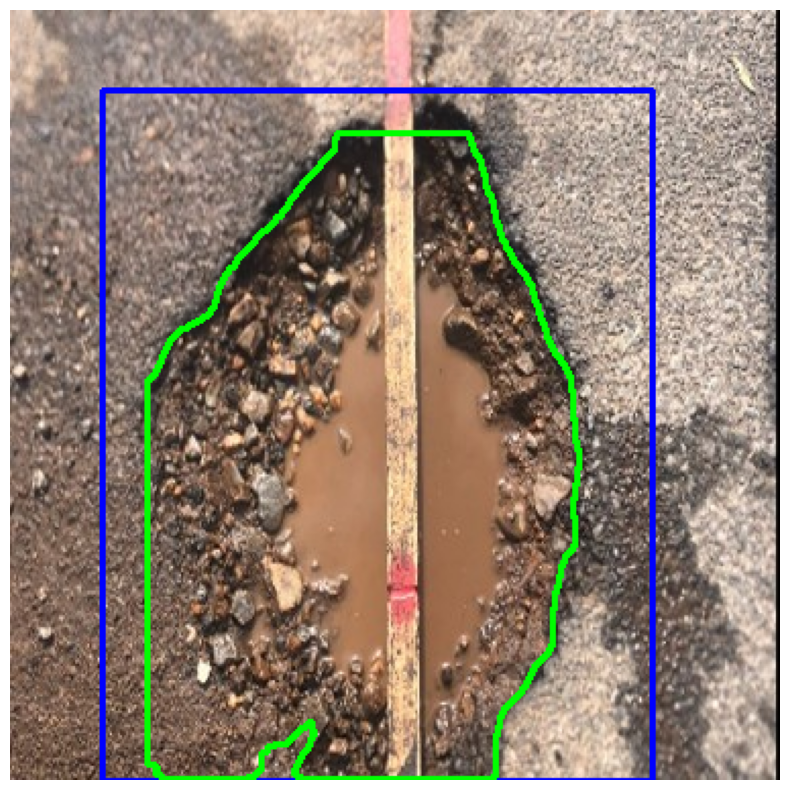

In [71]:
def plot_pothole_contour(image_path, bbox_model, segmentation_model, contour_threshold=0.5):
    """
    Predict and plot the pothole bounding box and contour on the original image using the segmentation model.
    :param image_path: Path to the original image.
    :param bbox_model: Trained YOLO bounding box model for detecting potholes.
    :param segmentation_model: Trained YOLO segmentation model for detecting pothole contours.
    :param contour_threshold: Threshold to apply to the mask for contour detection.
    :return: Image with the pothole bounding box and contour drawn, or None if the image could not be loaded.
    """
    # Load the original image
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image at {image_path}. Please check the file path.")
        return None

    # Step 1: Use the bounding box model to detect the pothole
    bbox_results = bbox_model.predict(source=image, save=False, verbose=False)

    if len(bbox_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        bbox = bbox_results[0].boxes.xyxy.cpu().numpy()[0].astype(int)

        # Draw the bounding box on the image
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue bounding box

        # Step 2: Use the segmentation model to predict the contour
        contour_results = segmentation_model.predict(source=image, conf=0.01, save=False, verbose=False)

        if contour_results[0].masks is not None:
            # Extract all the predicted masks
            masks = contour_results[0].masks.data.cpu().numpy()

            # Extract the confidence scores for the masks
            mask_scores = contour_results[0].boxes.conf.cpu().numpy()

            # Find the mask with the highest confidence score
            max_conf_idx = np.argmax(mask_scores)
            best_mask = masks[max_conf_idx]

            # Apply threshold to mask
            mask = (best_mask > contour_threshold).astype(np.uint8) * 255

            # Ensure the mask size matches the original image size
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

            # Find contours in the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                # Draw the predicted contours on the original image
                cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Green contours
            else:
                print("No contours found.")
        else:
            print("No masks found.")
    else:
        print(f"No pothole detected in the image: {image_path}")

    return image

# Example usage:
image_path = 'YOLO/Segmentation/original images/images/p1117.jpg'
output_image = plot_pothole_contour(image_path, pothole_model, segmentation_model, contour_threshold=0.5)

if output_image is not None:
    # Convert to RGB for displaying
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_rgb)
    plt.axis('off')
    plt.show()